In [10]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
# Instalar kmodes
!pip install kmodes
!pip install kneed

In [54]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.impute import KNNImputer
from sklearn.decomposition import PCA
from sklearn.preprocessing import LabelEncoder

from kmodes.kprototypes import KPrototypes

In [63]:
# Ler dataset em csv
Data = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/Dificuldades no Aprendizado.csv')

# Simplificar nomes das colunas
Data = Data.rename(columns={
    'Qual seu nome completo?' : 'Nome',
    'Qual sua idade? (Digite apenas números)' : 'Idade',
    'Qual seu sexo?' : 'Sexo',
    'Você trabalha?' : 'Trabalha',
    'Qual sua área de estudo?' : 'Area de estudo',
    'O seu ambiente de estudos atrapalha a sua concentração?' : 'Ambiente atrapalha',
    'Atualmente, você possui algum diagnóstico médico de distúrbio/transtorno que impacta suas habilidades cognitivas, como pensar, ler ou raciocinar?' : 'Possui disturbio',
    'Você tem dificuldade em memorizar os conteúdos que você estuda?' : 'Dificuldade de memorizar',
    'Você tem dificuldade em compreender os conteúdos que você estuda?' : 'Dificuldade de compreender',
    'Você consegue manusear bem seu tempo para estudar?' : 'Manuseia bem tempo',
    'Quanto tempo, em média, você se dedica a seus estudos?' : 'Tempo de estudo',
    'Você considera que seu emprego atual está atrapalhando seus estudos?' : 'Emprego atrapalha',
    'Você considera que suas redes sociais estão atrapalhando seus estudos?' : 'Redes sociais atrapalham',
    'Você acredita que seus problemas pessoais (sejam emocionais, financeiros, familiares, etc.) estão atrapalhando seus estudos?' : 'Problemas pessoais atrapalham',
    'Você ainda possui interesse na sua área de estudo atual?' : 'Ainda possui interesse'
})

# Simplificar respostas categóricas
for column in Data.columns:
    Data[column] = Data[column].apply(lambda x: 'Tecnologia' if str(x).startswith('Tecnologia')
                                            else 'Ciencias humanas' if str(x).startswith('Ciências humanas')
                                            else 'Ciencias naturais' if str(x).startswith('Ciências naturais')
                                            else 'Ciencias exatas' if str(x).startswith('Ciências exatas')
                                            else x)

In [41]:
# Função para converter idades
def convert_age(age_str):
  if "anos" in age_str:
    return int(age_str.replace(" anos", ""))
  else:
    return int(age_str)

# Função para converter binários
def convert_binary(value):
  if value == 'Sim':
    return '1'
  elif value == 'Não':
    return '0'
  else:
    return value

In [64]:
# Converter idades para numérico
Data['Idade'] = Data['Idade'].apply(convert_age)

# Selecionar dados numéricos
df_numeric = Data.select_dtypes(include=['int', 'float'])
display(df_numeric)

,Idade
0,34
1,19
2,16
3,19
4,15
...,...
62,19
63,19
64,19
65,19


In [ ]:
# Selecionar dados categóricos
categorical = [col for col in Data.columns if col != 'Idade']
df_categorical = Data[categorical]
display(df_categorical)

In [ ]:
df_categorical

In [ ]:
# Remover colunas Timestamp e Username, provenientes do formulário do Google
Data.drop(['Timestamp', 'Username', 'Nome'], axis='columns', inplace=True)

Data = Data.applymap(convert_binary)

In [68]:
dfMatrix = Data.to_numpy()
display(Data)

,Idade,Sexo,Trabalha,Area de estudo,Ambiente atrapalha,Possui disturbio,Dificuldade de memorizar,Dificuldade de compreender,Manuseia bem tempo,Tempo de estudo,Emprego atrapalha,Redes sociais atrapalham,Problemas pessoais atrapalham,Ainda possui interesse
0,34,Feminino,1,Outra,1,1,1,1,1,Entre 1 e 2 horas,1,1,1,1
1,19,Masculino,0,Tecnologia,0,0,1,1,1,Entre 2 e 4 horas,Não estou trabalhando,1,1,1
2,16,Masculino,0,Tecnologia,1,0,1,0,0,Entre 1 e 2 horas,Não estou trabalhando,1,0,1
3,19,Masculino,0,Tecnologia,1,0,1,1,0,Entre 2 e 4 horas,Não estou trabalhando,1,1,1
4,15,Feminino,0,Outra,0,0,0,1,1,Entre 2 e 4 horas,Não estou trabalhando,1,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
62,19,Feminino,0,Ciencias naturais,1,0,0,0,0,Entre 4 e 6 horas,Não estou trabalhando,1,1,1
63,19,Masculino,0,Ciencias naturais,0,0,0,0,0,Entre 1 e 2 horas,Não estou trabalhando,1,1,1
64,19,Feminino,0,Ciencias naturais,1,0,1,0,0,Entre 4 e 6 horas,Não estou trabalhando,1,1,1
65,19,Masculino,0,Ciencias naturais,0,1,1,0,1,Entre 2 e 4 horas,Não estou trabalhando,1,0,1


In [69]:
kprototype = KPrototypes(n_jobs = -1, n_clusters = 3, init = 'Huang', random_state = 0)
catColumnsPos = [Data.columns.get_loc(col) for col in list(Data.select_dtypes('object').columns)]
catColumnsPos

[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13]

In [48]:
print('Categorical columns           : {}'.format(list(Data.select_dtypes('object').columns)))
print('Categorical columns position  : {}'.format(catColumnsPos))

Categorical columns           : ['Sexo', 'Trabalha', 'Area de estudo', 'Ambiente atrapalha', 'Possui disturbio', 'Dificuldade de memorizar', 'Dificuldade de compreender', 'Manuseia bem tempo', 'Tempo de estudo', 'Emprego atrapalha', 'Redes sociais atrapalham', 'Problemas pessoais atrapalham', 'Ainda possui interesse']
Categorical columns position  : [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13]


In [ ]:
cost = []

for k in range(1, 10):
  try:
    kprototype = KPrototypes(n_clusters=k, init='Huang', verbose=2)
    kprototype.fit_predict(Data, categorical=catColumnsPos)
    cost.append(kprototype.cost_)
    print('Instanciação do cluster {}'.format(k))
  except:
    break

plt.plot(cost)
plt.xlabel('K')
plt.ylabel('cost')
plt.show

In [71]:
from kneed import KneeLocator
cost_knee_c3 = KneeLocator(
        x=range(1,10),
        y=cost,
        S=0.1, curve="convex", direction="decreasing", online=True)

K_cost_c3 = cost_knee_c3.elbow
print("Cotovelo em k =", f'{K_cost_c3:.0f} clusters')

Cotovelo em k = 3 clusters


In [76]:
# Transformar dados categóricos em numéricos
encoders={}
for col_name in df_categorical.columns:
    series = df_categorical[col_name]
    label_encoder = LabelEncoder()
    df_categorical[col_name] = pd.Series(label_encoder.fit_transform(series[series.notnull()]),
    index=series[series.notnull()].index
    )
    encoders[col_name] = label_encoder

df_categorical.drop(['Timestamp', 'Username', 'Nome'], axis='columns', inplace=True)
df_categorical

,Sexo,Trabalha,Area de estudo,Ambiente atrapalha,Possui disturbio,Dificuldade de memorizar,Dificuldade de compreender,Manuseia bem tempo,Tempo de estudo,Emprego atrapalha,Redes sociais atrapalham,Problemas pessoais atrapalham,Ainda possui interesse
0,0,1,3,1,1,1,1,1,0,2,1,1,1
1,1,0,4,0,0,1,1,1,1,1,1,1,1
2,1,0,4,1,0,1,0,0,0,1,1,0,1
3,1,0,4,1,0,1,1,0,1,1,1,1,1
4,0,0,3,0,0,0,1,1,1,1,1,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
62,0,0,2,1,0,0,0,0,2,1,1,1,1
63,1,0,2,0,0,0,0,0,0,1,1,1,1
64,0,0,2,1,0,1,0,0,2,1,1,1,1
65,1,0,2,0,1,1,0,1,1,1,1,0,1


In [90]:
Data=pd.concat([df_numeric, df_categorical], axis=1)
Data

,Idade,Sexo,Trabalha,Area de estudo,Ambiente atrapalha,Possui disturbio,Dificuldade de memorizar,Dificuldade de compreender,Manuseia bem tempo,Tempo de estudo,Emprego atrapalha,Redes sociais atrapalham,Problemas pessoais atrapalham,Ainda possui interesse
0,34,0,1,3,1,1,1,1,1,0,2,1,1,1
1,19,1,0,4,0,0,1,1,1,1,1,1,1,1
2,16,1,0,4,1,0,1,0,0,0,1,1,0,1
3,19,1,0,4,1,0,1,1,0,1,1,1,1,1
4,15,0,0,3,0,0,0,1,1,1,1,1,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
62,19,0,0,2,1,0,0,0,0,2,1,1,1,1
63,19,1,0,2,0,0,0,0,0,0,1,1,1,1
64,19,0,0,2,1,0,1,0,0,2,1,1,1,1
65,19,1,0,2,0,1,1,0,1,1,1,1,0,1


In [91]:
pca = PCA(2)
#Transform the data
d_f= pca.fit_transform(df_categorical)

d_f.shape

(67, 2)

In [93]:
#decode categorical data because k-prototype works with raw categorical data
for i in df_categorical.columns:
     Data[i]=Data[i].astype(int)
for col_name in df_categorical.columns:
    Data[col_name] = encoders[col_name].inverse_transform(Data[col_name])

In [ ]:
Data.info()

In [98]:
label = kprototype.fit_predict(dfMatrix, categorical = catColumnsPos)
print(label)

[2 1 1 1 1 1 2 0 1 1 1 0 0 0 0 0 2 0 1 1 1 1 1 2 1 1 1 0 1 0 1 1 1 1 0 1 1
 1 1 1 1 0 1 1 1 1 1 1 1 0 0 1 1 0 1 2 2 1 0 1 1 1 1 1 1 1 0]


In [99]:
kprototype = KPrototypes(n_jobs = -1, n_clusters = 3, init = 'Huang', random_state = 0)
Data['clusters']= kprototype.fit_predict(dfMatrix, categorical = catColumnsPos)

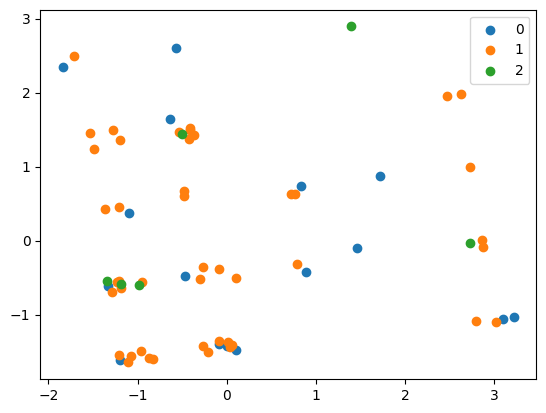

In [101]:
u_labels = np.unique(label)

# Plotagem de resultados:
for i in u_labels:
    plt.scatter(d_f[label == i , 0] , d_f[label == i , 1], label = i)
plt.legend()
plt.show()

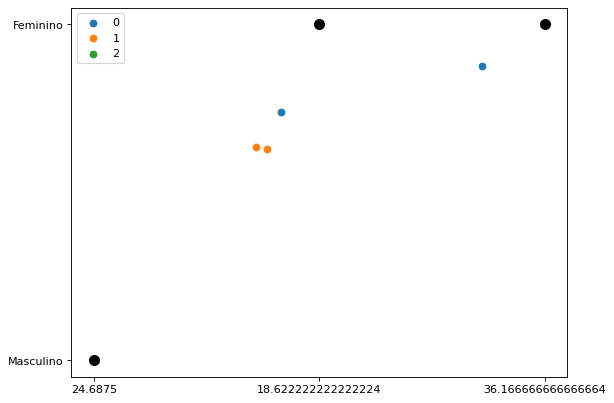

In [102]:
from matplotlib.pyplot import figure

centroids = kprototype.cluster_centroids_
u_labels = np.unique(label)
figure(figsize=(8, 6), dpi=80)

#plotting the results:

for i in u_labels:
    plt.scatter(d_f[label == i , 0] , d_f[label == i , 1] , label = i)
plt.scatter(centroids[:,0] , centroids[:,1] , s = 80, color = 'k')
plt.legend()
plt.show()

<Axes: xlabel='clusters'>

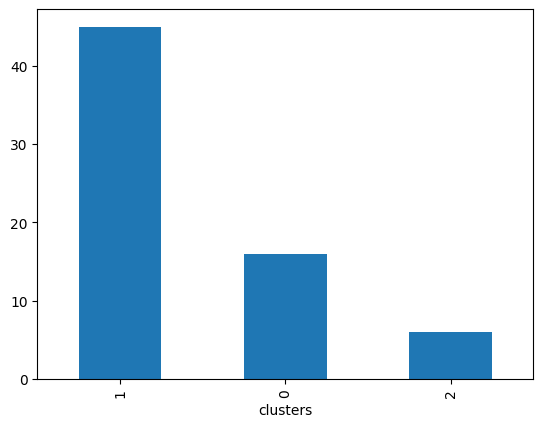

In [103]:
Data['clusters'].value_counts().plot(kind='bar')

In [104]:
Data.groupby(['clusters']).mean()

,Idade,Sexo,Trabalha,Area de estudo,Ambiente atrapalha,Possui disturbio,Dificuldade de memorizar,Dificuldade de compreender,Manuseia bem tempo,Tempo de estudo,Emprego atrapalha,Redes sociais atrapalham,Problemas pessoais atrapalham,Ainda possui interesse
clusters,,,,,,,,,,,,,,
0,24.687500,0.625000,0.625000,2.687500,0.687500,0.312500,0.375000,0.500000,0.375000,1.500000,1.000000,0.562500,0.625000,0.937500
1,18.622222,0.377778,0.422222,2.600000,0.466667,0.177778,0.644444,0.533333,0.244444,1.133333,0.733333,0.844444,0.688889,0.911111
2,36.166667,0.500000,0.666667,2.166667,0.500000,0.166667,0.500000,0.500000,0.666667,1.333333,0.666667,0.333333,0.833333,0.833333


In [113]:
Data.groupby(['clusters']).agg(lambda x: pd.Series.mode(x).iat[0])[['Idade', 'Trabalha', 'Tempo de estudo']]

,Idade,Trabalha,Tempo de estudo
clusters,,,
0,23,1,1
1,19,0,0
2,32,1,0
